In [4]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import numpy as np
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

In [5]:
final_data = pd.read_csv("Cleaned_data.csv")

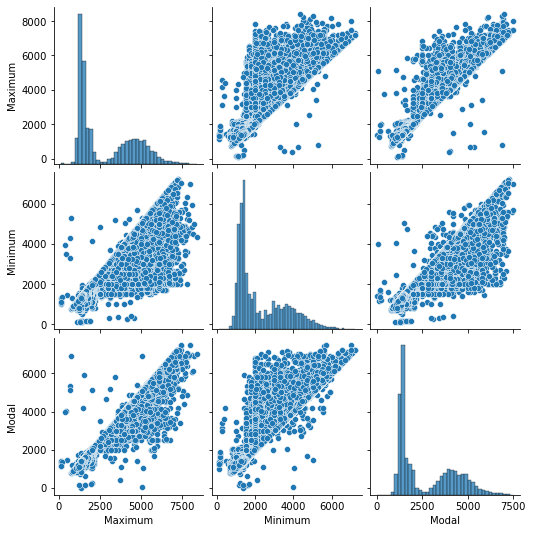

In [6]:
sns.pairplot(final_data.iloc[:, :]) 

In [7]:
lb_amc = LabelEncoder()
lb_crop = LabelEncoder()
final_data.Amc_Name = lb_amc.fit_transform(final_data.Amc_Name)
final_data.Crop = lb_crop.fit_transform(final_data.Crop)

In [8]:
#Split the data into train, validation and test
final_train = final_data.iloc[0:15167, 1:7] # Taking 2016-2018 data as training data
final_val =  final_data.iloc[15167:19262, 1:7]  # Taking 2019 data as validation data
final_test =  final_data.iloc[19262:21694, 1:7] # Taking 2021 data as test data

In [9]:
scaler = MinMaxScaler()
train = scaler.fit_transform(final_train)
val = scaler.fit_transform(final_val)
test = scaler.fit_transform(final_test)

In [10]:
X_train = []
Y_train = []
X_val = []
Y_val = []
timesteps = 1
X_train, Y_train = train[:, :-1], train[:, -1]
X_val, Y_val = val[:, :-1], val[:, -1]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [11]:
hl = [20,15] # hidden layers
lr = 1e-3
batch_size = 32
num_epochs = 50
model = Sequential()
model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True, activation = 'tanh'))
for i in range(len(hl)-1):        
    model.add(LSTM(hl[i], activation = 'tanh',return_sequences = True))
model.add(LSTM(hl[-1],activation = 'tanh'))

model.add(Dense(1))
model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error', metrics = ['accuracy'])


In [12]:
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_data = (X_val, Y_val),verbose = 2)

Epoch 1/50
474/474 - 6s - loss: 0.0245 - accuracy: 1.3187e-04 - val_loss: 0.0040 - val_accuracy: 2.4420e-04
Epoch 2/50
474/474 - 1s - loss: 0.0014 - accuracy: 1.3187e-04 - val_loss: 0.0034 - val_accuracy: 2.4420e-04
Epoch 3/50
474/474 - 1s - loss: 0.0011 - accuracy: 1.3187e-04 - val_loss: 0.0031 - val_accuracy: 2.4420e-04
Epoch 4/50
474/474 - 1s - loss: 0.0010 - accuracy: 1.3187e-04 - val_loss: 0.0028 - val_accuracy: 2.4420e-04
Epoch 5/50
474/474 - 1s - loss: 0.0010 - accuracy: 1.3187e-04 - val_loss: 0.0029 - val_accuracy: 2.4420e-04
Epoch 6/50
474/474 - 1s - loss: 9.8838e-04 - accuracy: 1.3187e-04 - val_loss: 0.0030 - val_accuracy: 2.4420e-04
Epoch 7/50
474/474 - 1s - loss: 9.8067e-04 - accuracy: 1.3187e-04 - val_loss: 0.0030 - val_accuracy: 2.4420e-04
Epoch 8/50
474/474 - 1s - loss: 9.8404e-04 - accuracy: 1.3187e-04 - val_loss: 0.0027 - val_accuracy: 2.4420e-04
Epoch 9/50
474/474 - 1s - loss: 9.7074e-04 - accuracy: 1.3187e-04 - val_loss: 0.0036 - val_accuracy: 2.4420e-04
Epoch 10/50


In [13]:
model.reset_states()

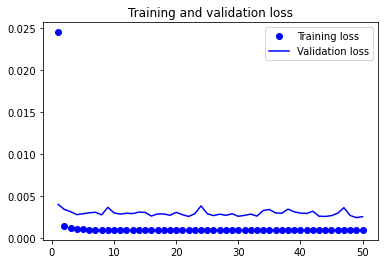

In [14]:
import matplotlib.pyplot as plt
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1) 
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [15]:
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Real time Price Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

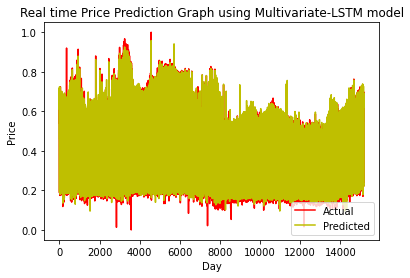

In [16]:
Y_train_pred = model.predict(np.array(X_train))
rmse_train = sqrt(mean_squared_error(Y_train, Y_train_pred))
train_acc = r2_score(Y_train,Y_train_pred) #Train Accuracy: 97%
plot_data(Y_train,Y_train_pred)

Train acc:  0.9766346372274619  Val acc:  0.9317736964722212


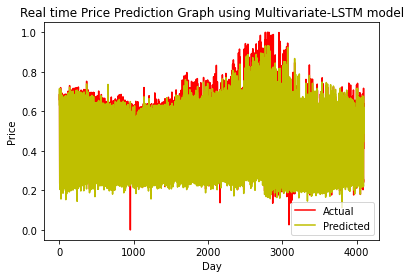

In [17]:
Y_val_pred = model.predict(X_val)
rmse_train = sqrt(mean_squared_error(Y_val, Y_val_pred))
val_acc = r2_score(Y_val,Y_val_pred) # Validation accuracy: 93%
print("Train acc: ",train_acc," Val acc: ",val_acc) 
plot_data(Y_val,Y_val_pred)

In [18]:
model.save("price_predict_model.h5")

In [19]:
# Test model on 2020 data
X_test = []
Y_test = []
X_test, Y_test = test[:, :-1], test[:, -1]
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Test acc:  0.9656595212781249


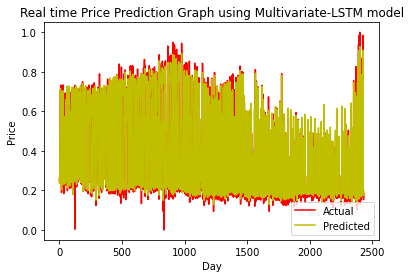

In [20]:
# Prediction Time !!!!
Y_hat = model.predict(X_test)
mse = mean_squared_error(Y_test,Y_hat)
rmse = sqrt(mse)
r = r2_score(Y_test,Y_hat) 
print("Test acc: ",r)  # Got an accuracy of 96%
plot_data(Y_test,Y_hat)